# Sound source localization with a microphones array : beamforming approaches

You have characterized and analyzed the sound propagation in the previous practical. We will now
exploit theses properties to infer one sound source position w.r.t. a linear microphone array made
of $N=8$ omnidirectional MEMS microphones. The system you will be using is the same as before;
thus, most of the code you already wrote to acquire signals, plot them, etc. will remain the same.

In all the following, the acquisition system will work with a sampling frequency $F_s = 20$kHz, and with a buffer of size $\texttt{BLK} = 1024$.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from client import array
import time

c:\Users\hp\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
# Use one or the other option ... not the two at the same time!
antenne=array('server') # When performing real-time acquisition


In [2]:
antenne=array('play')   # When playing recorded files

In [81]:
# Load acquisition and array parameters from the antenne variable, after launching acquisition or play
Fs = antenne.fs
BLK = antenne.blocksize
N = len(antenne.mu32.mems)
d = antenne.interspace

### 1) To begin, start the acquisition of the audio system, and capture one audio buffer. Plot the resulting signals as a function of time.

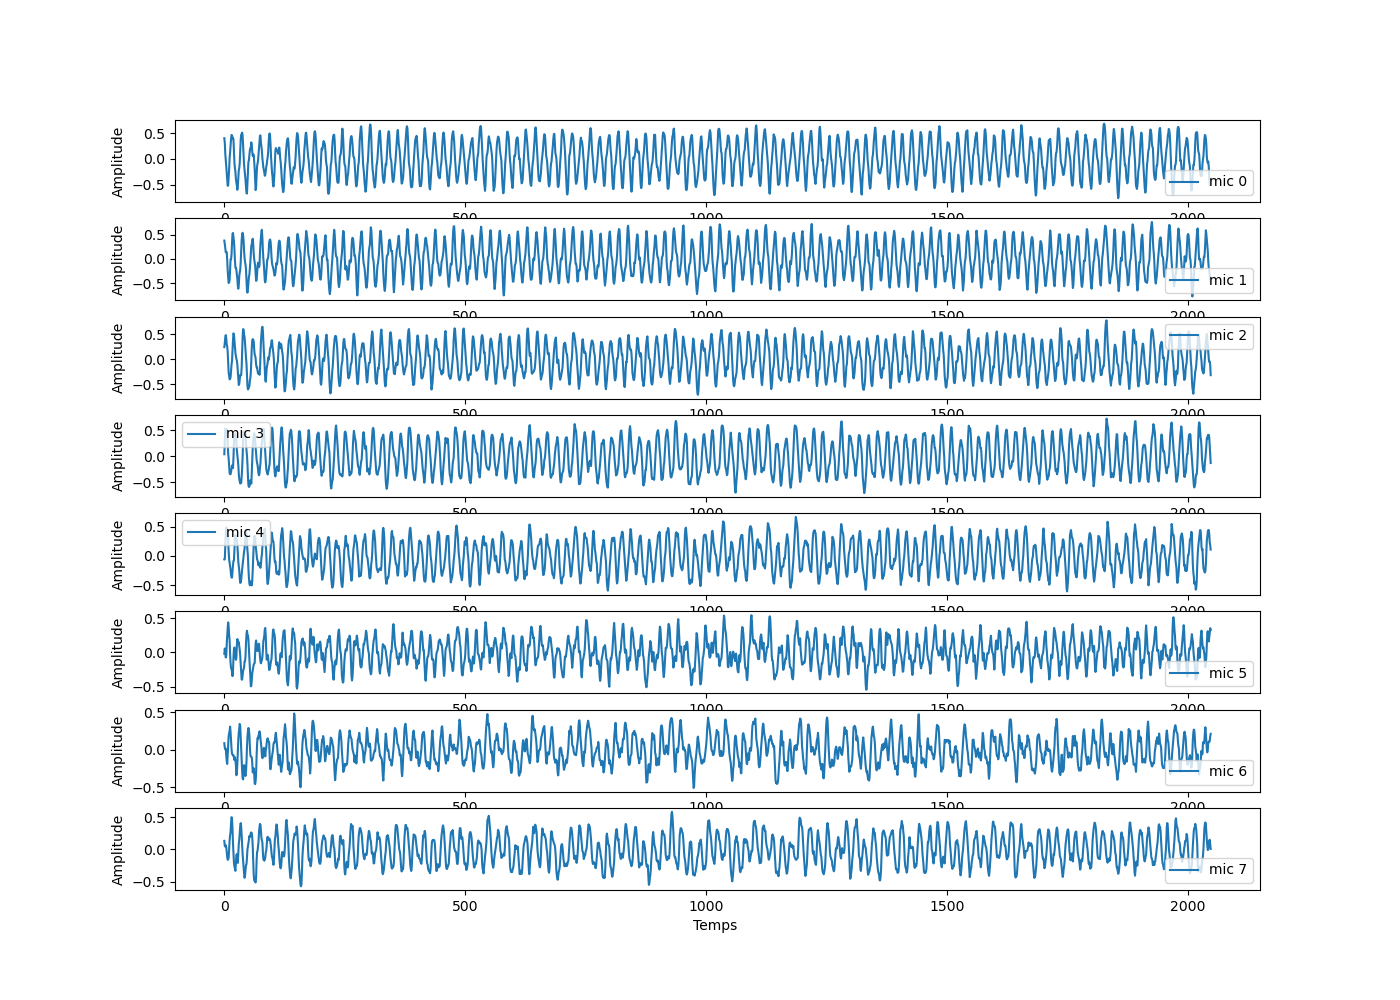

In [82]:
# Read an audio buffer
m = antenne.read()

plt.figure(figsize=[14,10])

for i in range(8) :
    plt.subplot(8,1,i+1)
    plt.plot(m[:,i], label="mic " + str(i))
    plt.xlabel('Temps ')
    plt.ylabel('Amplitude')
    plt.legend()
plt.show()

## 2.1/ Coding the beamformer filters and analyzing their properties

**These first questions have to be prepared before the practical session**

### 2) Write the position $z_n$ as a function of $n$ and interspace $d$. As a convention, the first microphone number is selected as $0$.

One can write :
$$z_n =  d(n- \frac{N-1}{2})$$

### 3) Propose a function `beam_filter` returning the filter frequency response for one microphone number `mic_nb`. 

In [62]:
def beam_filter(array, freq_vector, theta0=0, mic_nb: int = 0):

    """Compute the filter frequency response of a DSB beamformer for one microphone
    Args:
        array (array_server obj): array structure controlling the acquisition system.
        freq_vector (np.array): frequency vector. 
        theta0 (int, optional): focusing angular direction (in degrees). Defaults to 0.
        mic_id (int, optional): microphone id. Defaults to 0.

    Returns:
        np.array: the filter frequency response. Shape is (len(freq_vector),).
    """
    N = len(antenne.mu32.mems)
    d = antenne.interspace

    # Microphone position x
    z = d*(mic_nb - (N - 1 )/2) # TO BE COMPLETED

    # Filter's frequency response
    return np.exp( -1j * 2 * np.pi * freq_vector /340 * z *np.cos ( theta0 * np.pi / 180 ))

### 4) Plot the two frequency responses obtained for two filters associated to two different microphone outputs when $\theta_0=0^\circ$ and for frequencies between $0$ and $5$kHz. Explain the effect of these filters on the signals.

C:\Users\hp\AppData\Local\Temp\ipykernel_15088\2766878534.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[14,5])


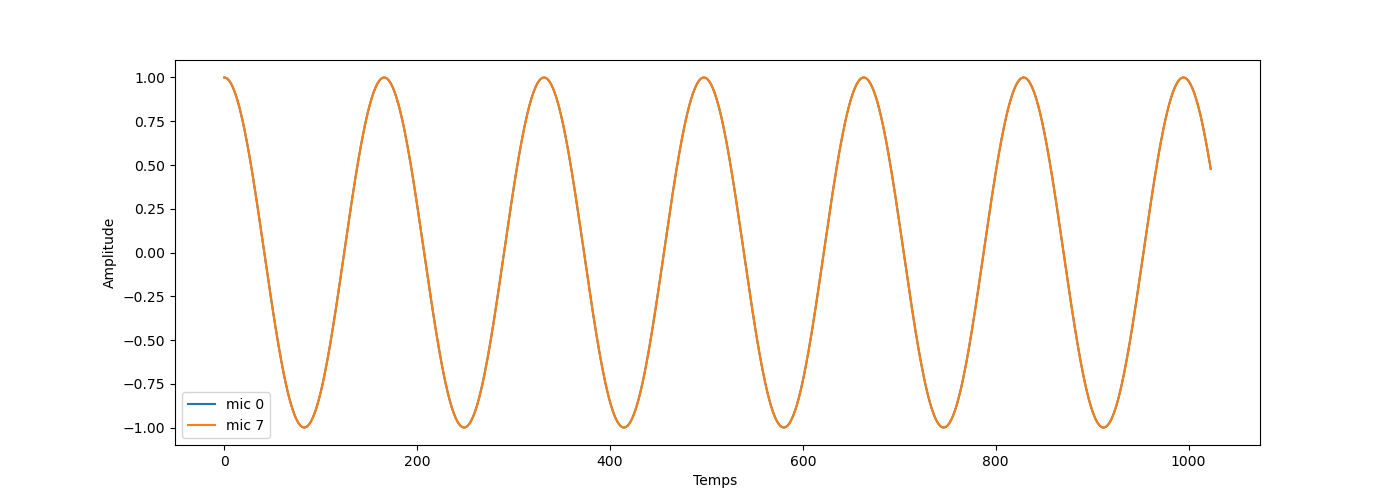

In [63]:
def FT(Y,N,fs):
    yf = np.fft.fft(Y)[:N//2]
    xf = np.fft.fftfreq(N, 1/fs)[:N//2]
    return yf,xf


Fy0 , Fx0 = FT(m[:,0], 2048,20000)
Fy7 , Fx7 = FT(m[:,7], 2048,20000)

Fr0 = beam_filter(m, Fx0, 0 , 0)
Fr7 = beam_filter(m, Fx0, 0 , 7)


plt.figure(figsize=[14,5])
plt.plot(Fr0, label="mic 0")
plt.plot(Fr7, label="mic 7")
plt.legend()
plt.xlabel('Temps ')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Some comments.

### 5) Compare again the filters obtained when $\theta_0 = 90^\circ$. Explain the differences.

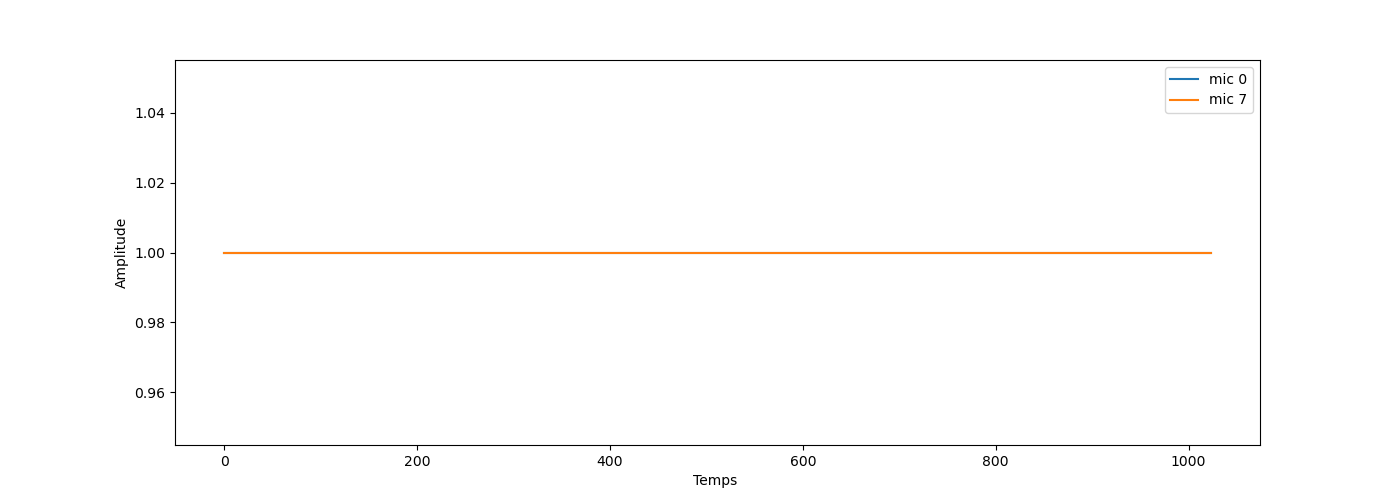

In [64]:
def FT(Y,N,fs):
    yf = np.fft.fft(Y)[:N//2]
    xf = np.fft.fftfreq(N, 1/fs)[:N//2]
    return yf,xf

Fy0 , Fx0 = FT(m[:,0],2048,20000)
Fy7 , Fx7 = FT(m[:,7],2048,20000)

Fr0 = beam_filter(m, Fx0, 90 , 0)
Fr7 = beam_filter(m, Fx0, 90 , 7)


plt.figure(figsize=[14,5])
plt.plot(Fr0, label="mic 0")
plt.plot(Fr7, label="mic 7")
plt.legend()
plt.xlabel('Temps ')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Some comments

## 2.2/ Using the filters : coding of the beamforming
Basically, the beamforming algorithm is the following :

- (a) acquire an audio frame
- (b) compute the corresponding FFT
- (c) analyze the FFT to define which frequency(ies) you would like to localize
- (d) restrict the FFT to the frequencies of interest
- (e) for one given ✓ 0 , for the frequencies selected before, and for each microphone :
  — compute the corresponding filters frequency responses with the beam_filter func-
tion
  — apply these filters to the microphone outputs
- (f) compute the beamformer output associated to the angular polarization ✓ 0
- (g) repeat all these last steps for each ✓ 0 you want to test
- (h) finally, decide of the angular position of the source by detecting for which ✓ 0 the beam-
former output is maximum.

### 6) Step (a) and (b) : After acquiring an audio buffer, compute its FFT in an array $M_{fft}$. Plot the result of this analysis as a function of the frequency when emitting a pure sine tone with a frequency $F_0 = 1$kHz.

In [101]:
def FT(Y,N,fs):
    yf = np.fft.fft(Y)[:N//2]
    xf = np.fft.fftfreq(N, 1/fs)[:N//2]
    return yf,xf

Mfft = np.zeros([N, 2048//2],dtype=complex)
Ffft = np.zeros([N, 2048//2])

for i in range(N) :
    Fy , Fx = FT(m[:,i],2048,20000)
    Mfft[i,:] = Fy
    Ffft[i,:] = Fx


plt.figure(figsize=[12,5])
plt.plot(Ffft[0],abs(Mfft[0]),label="mic 0")
plt.plot(Ffft[1],abs(Mfft[1]),label="mic 1")
plt.plot(Ffft[2],abs(Mfft[2]),label="mic 2")
plt.plot(Ffft[3],abs(Mfft[3]),label="mic 3")
plt.plot(Ffft[4],abs(Mfft[4]),label="mic 4")
plt.plot(Ffft[5],abs(Mfft[5]),label="mic 5")
plt.plot(Ffft[6],abs(Mfft[6]),label="mic 6")
plt.plot(Ffft[7],abs(Mfft[7]),label="mic 7")
plt.ylabel('Amplitude')
plt.xlabel('Fréquence')
plt.legend()
plt.show()


IndexError: invalid index to scalar variable.

0

Some comments

### 7) Step (c) and (d) : Among all the frequencies you obtained from the FFT, select the one corresponding to the source frequency. Give its exact value and index $k_0$ in the frequency array, and collect the corresponding FFT values of each microphone outputs in one vector $\texttt{M}$ of length $N$.

In [67]:

k = np.zeros(N)

for i in range(N) :
    k[i] = np.argmax(abs(Mfft[i]))

vs, c = np.unique(k, return_counts=True)
k0 = int(vs[np.argmax(c)])

M = Mfft[:,k0]

for i in range(N) :
    print(f' mic {i} : k0= {k0}, fmax= {Ffft[i,k0]}, M = {M[i]}' )

 mic 0 : k0= 108, fmax= 1054.6875, M = -166.52372460249705
 mic 1 : k0= 108, fmax= 1054.6875, M = -2.3939734125782084
 mic 2 : k0= 108, fmax= 1054.6875, M = 177.4790820759594
 mic 3 : k0= 108, fmax= 1054.6875, M = 277.30935138068537
 mic 4 : k0= 108, fmax= 1054.6875, M = 220.76697070119212
 mic 5 : k0= 108, fmax= 1054.6875, M = 52.17307255627793
 mic 6 : k0= 108, fmax= 1054.6875, M = -123.56062291198111
 mic 7 : k0= 108, fmax= 1054.6875, M = -180.27671036716487


Some comments

### 8) Step (e) : In a loop among all microphones, compute each filters for the position $\theta_0$ and for the frequency value you obtained in the previous step. Apply then these filters to the array $\texttt{M}$ defined before.

In [94]:
theta = 45
Mf = np.zeros(N, dtype=complex)
for i, m in enumerate(M) :
    Mf[i] = beam_filter( M[i], 1054.6875, theta , i)

print(Mf)

[-0.96955502+0.24487355j -0.47634386+0.87925908j  0.3244436 +0.94590504j
  0.9157371 +0.401778j    0.9157371 -0.401778j    0.3244436 -0.94590504j
 -0.47634386-0.87925908j -0.96955502-0.24487355j]


### 9) Step (f): Combine then the filters outputs to form the beamformer output $Y_{\theta_0}[k_0]$. *$Y_{\theta_0}[k_0]$ is obviously a complex value which corresponds to the frequency contribution of the source to the $k_0^{\text{th}}$ frequency component of the beamformer output when focalized in the direction $\theta_0$.* Compute then the corresponding power $P(\theta_0)$ at $k_0$ of the beamformer output.

In [95]:
Y = sum(M * Mf)/8
P = abs(Y)**2

print("P = ", P)

P =  14408.40787645207


Some comments

### 10) For a direction $\theta_0$ of your choice, compute $P(\theta_0)$ for (i) a source emitting from a direction close to $\theta_0$, or (ii) far from it. Compare the two values.

In [88]:
# all the code 

def compute_P(m, theta):

    WS, N = m.shape
    Mfft = np.zeros([N, WS//2],dtype=complex)
    Ffft = np.zeros([N, WS//2])

    for i in range(N) :
        Fy , Fx = FT(m[:,i],2048,20000)
        Mfft[i,:] = Fy
        Ffft[i,:] = Fx

    k = np.zeros(N)

    for i in range(N) :
        k[i] = np.argmax(abs(Mfft[i]))

    vs, c = np.unique(k, return_counts=True)
    k0 = int(vs[np.argmax(c)])

    M = Mfft[:,k0]

    theta
    Mf = np.zeros(N, dtype=complex)
    for i, m in enumerate(M) :
        Mf[i] = beam_filter( M[i], 1054.6875, theta , i)

    Y = sum(M * Mf)/8
    return abs(Y)**2

    

In [92]:
# For theta_s ~ X° 45
compute_P(m, 45)

1222.4047157923872

In [ ]:
# For theta0 ~ Y° 45
compute_P(m, 90)

Some comments

### 11) Step (g) : Repeat now the previous code in a loop for $\theta_0$ values ranging from 0 to 180° .You should then obtain an array $\texttt{P}$ where each value corresponds to the power of the beamformer output at $F_0$ for each angular polarization. Plot the array $\texttt{P}$ as a function of the angle $\theta_0$.

In [ ]:
# TO BE COMPLETED

Some comments

### 12) Step (h) : Find the $\theta_0$ value corresponding to position of the maximum in $\texttt{P}$ and compare it with the actual (but approximate) position of the sound source.

In [ ]:
# TO BE COMPLETED

Some comments.

## 2.3/ Analyzing the beamformer performances

From now on, you can use your own code written in Section 2.2, or use the provided beamformer function which exactly reproduces the beamformer algorithm. You might then add `from beamformer_etu import beamformer` in your Notebook before being able to use the beamformer function.

In [ ]:
from beamformer_etu import beamformer

### 13) Plot the energy maps you obtain when using source frequencies $F_0 = 400$Hz, $F_0 = 1$kHz, $F_0 = 2$kHz and $F_0 = 4$kHz emitting from a fixed arbitrary position. Comment and explain carefully the differences between these curves

In [ ]:
# TO BE COMPLETED

Some comments

### 14) For a frequency $F_0 = 1$kHz and a source moving aroud the array, plot the estimated position as a function of time. Comment the effectiveness of the approach and its limits.

In [ ]:
# TO BE COMPLETED

Some comments